# Bài toán dữ liệu ngân hàng
Một ngân hàng đang có kết quả kinh doanh không tốt, tỉ lệ khách hàng ngưng sử dụng dịch vụ tín dụng rất cao. Họ cho rằng định hướng kinh doanh của mình đang gặp một số trục trặc, xu hướng đã thay đổi. Nhà khoa học dữ liệu cần đưa ra các phân tích cụ thể về xu hướng nguyên nhân và giải pháp khắc phục vấn đề này...
Bộ dữ liệu được sử dụng Bankchunks(https://www.kaggle.com/datasets/syviaw/bankchurners)
## Hướng giải quyết bài toán:##
Bài phân tích hoàn toàn sử dụng các công cụ trực quan hoá dữ liệu(bảng, biểu đồ) bằng ngôn ngữ ***Python*** đối tượng nghiên cứu chính là tình trạng sử dụng thẻ tín dụng(còn sử dụng hoặc không sử dụng). Cần tối đa hoá các công cụ trực quan để mọi người đều đọc hiểu được.
*Quy trình phân tích dữ liệu được thực hiện theo các bước sau:*
1. Làm sạch, tiền xử lý dữ liệu:
    - Xử lý dữ liệu missing.
    - Xác định ngoại lại và đòn bẩy.
    - Trích lọc thuộc tính không có tác dụng trong phân tích.
    - Mô phỏng và cân bằng dữ liệu không cân bằng.
2. Xác định xu hướng sử dụng dịch vụ của khách hàng:
    - Phân tích trực quan hoá xu hướng bằng thống kê bayer analyst, Logitic analyst, và histogram analyst
    - Phân tích trực quan hoá xu hướng bằng tối ưu hoá mô hình học máy desision tree
3.  Phân khúc khách hàng(những khách hàng có xu hướng có nhiều điểm chung về thói quen tài chính,đặt ra các điều tra các phân khúc khách hàng về mức độ hài lòng của dịch vụ)
    - Phân khúc khách hàng bằng mô hình học không giám sát Kmean, phân tách dữ liệu cao chiều
    - Trực quan hoá phân khúc
4.  Mô hình trí tuệ nhân tạo dự báo trạng thái sử dụng dịch vụ của khách hàng trong tương lai(F1_score = 97%):
    - Mô hình trí tuệ nhân tạo học máy tăng cường Gradient Boosting
    - Trực quan hoá mô hình

# Khởi tạo môi trường

In [ ]:
!pip install imblearn
!pip install statsmodels
!pip install scipy
!pip install sklearn
!pip install matplotlib --upgrade
!pip install dtreeviz


In [ ]:
# import thư viện
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
import warnings
warnings.filterwarnings('ignore')
import matplotlib.patches as mpatches
from statsmodels.formula.api import ols
import statsmodels.api as sm
from scipy.stats.mstats import zscore
from imblearn.under_sampling import RandomUnderSampler
from statsmodels.api import add_constant

In [ ]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Download data

In [ ]:
!mkdir ~/.kaggle
!pip install -q kaggle
kaggle_username =''
kaggle_key = ''
!echo '{"username":"nhamnguyen","key":"a27bb5f344e26b357dd6797fe1f11356"}' > ~/.kaggle/kaggle.json
!kaggle datasets download -d syviaw/bankchurners
!unzip bankchurners

100% 379k/379k [00:00<00:00, 565kB/s]
100% 379k/379k [00:00<00:00, 565kB/s]
Archive:  bankchurners.zip
  inflating: BankChurners.csv        


#Tổng quan dữ liệu


## Read and raw data

In [ ]:
data = pd.read_csv('/content/BankChurners.csv').iloc[:,:21]
df =data.copy()
data.head(5)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


## Mô tả dữ liệu

In [ ]:
data.describe()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


###Thông tin thuộc tính dữ liệu<br>
Bộ dữ liệu có 10127 hàng với 21 cột, đối tượng dự báo Attrition flag(tình trạng sử dụng tín dụng)
- CLIENTNUM: Id khách hàng 10127 giá trị
- Attrition_Flag: Tình trạng sử dụng của khách hàng(còn sử dụng hoặc không sử dụng). Thuộc tính gồm 10127 mẫu (Existing Customer: đã ngưng dịch ngân hàng, Attrition Customer: còn sử dụng dịch vụ ngân hàng)
- Customer_Age: Tuổi của khách hàng trung Thuộc tính gồm 10127 mẫu,  bình tuổi khách hàng 46,3 tuổi. Phương sai tuổi khách hàng là 8.0.
- Gender: Biến nhân khẩu học,giới tính (male,femail)
- Dependent_count: Biến nhân khẩu học, số người phụ thuộc. Thuộc tính gồm 10127 mẫu
- Education_Level: Biến nhân khẩu học trình độ học vấn của chủ tài khoản(Cử nhân, trung học phổ thông ...). 
- Marital_Status: Biến nhân khẩu học tình trạng hôn nhân của khách hàng(đã kết hôn, đang độc thân, ly hôn, không xác định)
- Income_category: Xếp hạng thu nhập(nhỏ hơn 40k, hơn 40k-60k ...)
- Card_category: Loại thẻ tín dụng(xanh,bạc,vàng,bạch kim)
- Months_on_book: Thời gian liên lạc với khách hàng trên 1 tháng(trung bình 36 phút, phương sai 7.99 phút)
- Total_Relationship_Count: Tổng số sản phẩm khách hàng nắm giữ(trung bình 3.81,phương sai 1.55)
- Months_Inactive_12_mon: Số tháng không hoạt động trong 12 tháng gần nhất(trung bình 2.34, phương sai 1.01)
- Contacts_Count_12_mon: Số lần liên hệ của khách hàng trong 12 tháng gần nhất(Trung bình 2.5 lần,phương sai 1)
- Credit_Limit: Giới hạn tín dụng của thẻ(hạn mức trung bình 8.63k, phương sai 9.09k)
- Avg_Open_To_Buy: Hạn mức mở để mua hạn mức tín dụng(Hạn mức trung bình 7.47k)
- Total_Amt_Chng_Q4_Q1: Thay đổi về số tiền giao dịch(trung bình thay đổi giao dịch 0.76 lần, phương sai 0.22 lần)
- Total_Trans_Amt: Tổng số tiền giao dịch(Trung bình số tiền giao dịch 4.4k, phương sai 3.4k)
- Total_Trans_Ct: Tổng số giao dịch(trung bìnhbình 64.9 lần phương sai 23.5 là)
- Total_Ct_Chng_Q4_Q1: Số lượng giao dịch thay đổi(trung bình 0.71, phương sai 0.24)
- Avg_Utilization_Ratio: Tỉ lệ sử dụng thẻ tín dụng trung bình(tb 0.27, phương sai 0.28)

# Xử lý dữ liệu


##Làm sạch và tiền xử lý dữ liệu


Quy trình làm sạch và tiền xử lý dữ liệu:<br>
    **1. Data cleaning<br>
    2. Feature Selection**

**Tình trạng sử dụng tín dụng của khách hàng và chất lượng bộ dữ liệu**

[8500. 1627. 7081. 3046.]


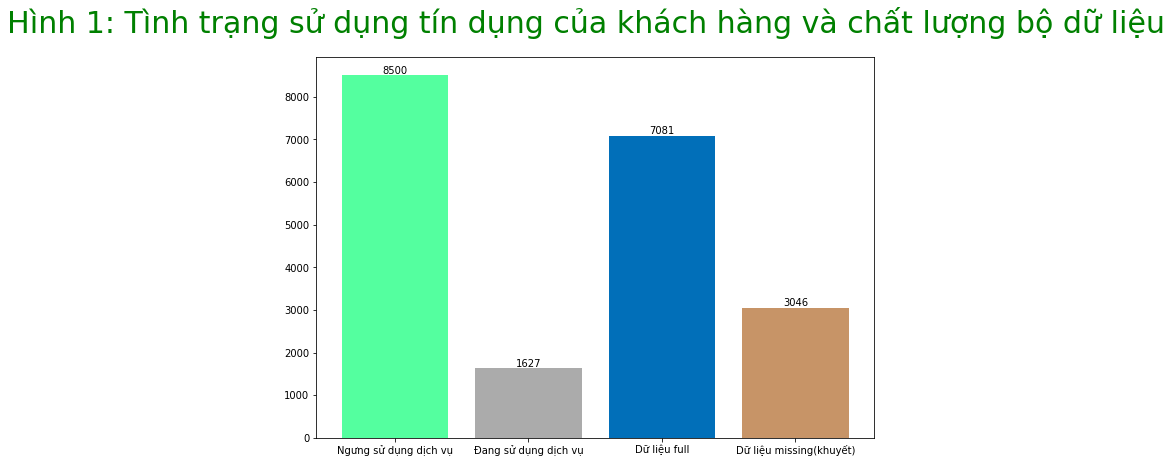

In [ ]:
bars = np.array([[8500,1627,7081,10127-7081],[0.83934038,0.16065962, 0.69921991, 0.30078009]])
print(bars[0])
names = ['Ngưng sử dụng dịch vụ','Đang sử dụng dịch vụ','Dữ liệu full','Dữ liệu missing(khuyết)']
fig, ax = plt.subplots(figsize = (10,7))
size = 0.5
bar = ax.bar(names,bars[0],color = ['#54ff9f','#ababab','#016fb9','#c79467'])
ax.bar_label(bar)
plt.suptitle('Hình 1: Tình trạng sử dụng tín dụng của khách hàng và chất lượng bộ dữ liệu', fontsize='30',color = 'green')
plt.show()

### Trạng thái tín dụng và chất lượng của bộ dữ liệu:
1. Trạng thái tín dụng:
    - Trong tổng số 10127 đối tượng đang nghiên cứu có 8500 khách hàng đã ngưng sử dụng thẻ tín dụng(chiếm 83%). Tổng số khách còn sử dụng dịch vụ là 1627(chiếm 17%).<br>
2. Chất lượng bộ dữ liệu:
    - Bộ dữ liệu có 3046(chiếm 30%) dữ liệu missing(khuyết 1 thuộc tính nào đó) trong tổng số 10127 mẫu.
**Kết luận:** <br>
Đây là bộ dữ liệu thô cần làm sạch.<br>
    - Tỉ lệ người dừng dịch vụ rất cao so với người còn sử dụng dịch vụ (gấp 4.88)<br>
    - Bộ dữ liệu nghiên cứu là bộ dữ liệu không cân bằng -> phải bằng dữ liệu<br>
    - Bộ dữ liệu có nhiều dữ liệu thiếu -> phải có các bước làm sạch và tiền xử lí<br>
**Quy trình làm sạch dũ liệu thô**
1. Drop giá trị khuyết và Mô phỏng dữ liệu phi cân bằng
2. Xác định ngoại lai, đòn bẩy
3. Lựa chọn thuộc tính(feature selection)

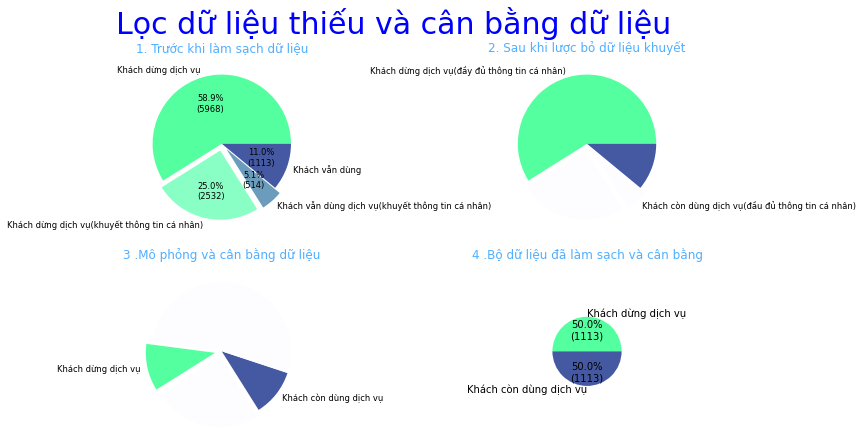

In [ ]:
def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

fig,ax = plt.subplots(2,2,figsize =(12,7))
ax[0,0].pie([5968,8500-5968,1627-1113,1113],colors =['#54ff9f','#89ffc5','#6c9cbc','#4459a2'],labels =['Khách dừng dịch vụ','Khách dừng dịch vụ(khuyết thông tin cá nhân)','Khách vẫn dùng dịch vụ(khuyết thông tin cá nhân)','Khách vẫn dùng'],textprops={'size': 'smaller'},explode=[0,0.1,0.1,0],autopct=lambda pct: func(pct, [5968,8500-5968,1627-1113,1113]))
ax[0,0].set_title('1. Trước khi làm sạch dữ liệu',color = '#51afff')
ax[0,1].pie([5968,8500-5968,1627-1113,1113],colors =['#54ff9f','#fdfdff','#fdfdff','#4459a2'],labels =['Khách dừng dịch vụ(đầy đủ thông tin cá nhân)','','Khách còn dùng dịch vụ(đầu đủ thông tin cá nhân)',''],textprops={'size': 'smaller'},explode=[0,0.1,0.1,0])
ax[0,1].set_title('2. Sau khi lược bỏ dữ liệu khuyết',color = '#51afff')
ax[1,0].pie([5968-1113, 1113, 2532, 1113, 514],colors =['#fdfdff','#54ff9f','#fdfdff','#4459a2','#fdfdff'],labels =['','Khách dừng dịch vụ','','Khách còn dùng dịch vụ',''],textprops={'size': 'smaller'},explode=[0,0.1,0.1,0,0])
ax[1,0].set_title('3 .Mô phỏng và cân bằng dữ liệu',color = '#51afff')
ax[1,1].pie([2226/2,2226/2],labels = ['Khách dừng dịch vụ','Khách còn dùng dịch vụ'],radius =0.5,colors = ['#54ff9f','#4459a2'],autopct=lambda pct: func(pct, [2226/2,2226/2]))
ax[1,1].set_title('4 .Bộ dữ liệu đã làm sạch và cân bằng',color = '#51afff')
plt.suptitle('Lọc dữ liệu thiếu và cân bằng dữ liệu', fontsize='30',color = 'blue')
plt.show()

In [ ]:
#data cleaning
df =data.drop(columns = 'CLIENTNUM')
data_analyst = df[data!='Unknown'].dropna()# xoa outlier
data_analyst = pd.get_dummies(data_analyst,drop_first=True)#Xử lý dữ liệu định tính

Xtrain = data_analyst.drop(columns =['Attrition_Flag_Existing Customer'])
Ytrain = data_analyst['Attrition_Flag_Existing Customer']
Undersampling = RandomUnderSampler(sampling_strategy=1)# Mô phỏng dữ liệu
X_under, y_under = Undersampling.fit_resample(Xtrain, Ytrain)

data_analyst_resamling =X_under
data_analyst_resamling['Attrition_Flag_Existing Customer'] = y_under

In [ ]:
data_analyst_resamling

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,...,Marital_Status_Married,Marital_Status_Single,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver,Attrition_Flag_Existing Customer
0,62,0,49,2,3,3,1438.3,0,1438.3,1.047,...,1,0,0,0,0,1,0,0,0,0
1,54,1,40,2,3,1,1438.3,808,630.3,0.997,...,1,0,0,0,0,1,0,0,0,0
2,56,2,36,1,3,3,15769.0,0,15769.0,1.041,...,1,0,0,0,0,0,0,0,0,0
3,48,2,35,2,4,4,34516.0,0,34516.0,0.763,...,1,0,0,1,0,0,0,0,1,0
4,53,2,41,3,3,2,11669.0,2227,9442.0,0.622,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2221,42,4,28,5,2,4,2205.0,1245,960.0,0.925,...,1,0,0,0,0,1,0,0,0,1
2222,60,0,41,3,2,4,2458.0,1880,578.0,0.759,...,1,0,1,0,0,0,0,0,0,1
2223,52,1,40,5,1,1,4745.0,1227,3518.0,0.624,...,0,1,0,0,1,0,0,0,0,1
2224,51,1,36,3,4,2,1857.0,1033,824.0,0.950,...,1,0,0,0,0,1,0,0,0,1


In [ ]:
data_analyst_tree

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,...,Education_Level_Uneducated,Marital_Status_Married,Marital_Status_Single,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,45,3,39,5,1,3,12691.0,777,11914.0,1.335,...,0,1,0,0,1,0,0,0,0,0
1,49,5,44,6,1,2,8256.0,864,7392.0,1.541,...,0,0,1,0,0,0,1,0,0,0
2,51,3,36,4,1,0,3418.0,0,3418.0,2.594,...,0,1,0,0,0,1,0,0,0,0
4,40,3,21,5,1,0,4716.0,0,4716.0,2.175,...,1,1,0,0,1,0,0,0,0,0
5,44,2,36,3,1,2,4010.0,1247,2763.0,1.376,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10120,54,1,34,5,2,0,13940.0,2109,11831.0,0.660,...,0,0,1,0,1,0,0,0,0,0
10121,56,1,50,4,1,4,3688.0,606,3082.0,0.570,...,0,0,1,0,0,0,1,0,0,0
10122,50,2,40,3,2,3,4003.0,1851,2152.0,0.703,...,0,0,1,1,0,0,0,0,0,0
10124,44,1,36,5,3,4,5409.0,0,5409.0,0.819,...,0,1,0,0,0,0,1,0,0,0


### Feature selection
Trong tất cả các thuộc tính(cột) của bộ dữ liệu thô, không phải thuộc tính nào cũng là thuộc tính ảnh hưởng đến đến đối tượng phân tích. Giả sử nhiệt độ phòng không hề ảnh hưởng tới tiền lương của nhân viên trong văn phòng ấy. Những thuộc tính ấy là dữ liệu nhiễu. Nếu sử dụng chúng để phân tích, kết quả , nhận định cuối cùng sẽ kém chính xác.<br>
**Nhận Xét**:<br>
Đây là bộ dữ liệu tài chính nên sẽ định hướng dùng các mô hình *Hồi quy đa biến* và *desision tree*
### Giả thuyết không:
    - Gọi H0 là giả thuyết: "Trọng số beta trong mô hình hồi quy logitic bằng không(Trọng số 2-Tailed test)". 
    - Giả thuyết bị bác bỏ nếu |T_score|>3.18 hoặc Pvalue nhỏ hơn 0.025 (95% confidence 2-Tailed).
    - Với p_value >0.025 bác bỏ giả thuyết 0. Ta chấp nhận với các giá trị p_value >0.025 trọng số Beta trong mô hình hồi quy logitic bằng 0.

Index(['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Gender_M', 'Education_Level_Doctorate', 'Education_Level_Graduate',
       'Education_Level_High School', 'Education_Level_Post-Graduate',
       'Education_Level_Uneducated', 'Marital_Status_Married',
       'Marital_Status_Single', 'Income_Category_$40K - $60K',
       'Income_Category_$60K - $80K', 'Income_Category_$80K - $120K',
       'Income_Category_Less than $40K', 'Card_Category_Gold',
       'Card_Category_Platinum', 'Card_Category_Silver',
       'Attrition_Flag_Existing Customer'],
      dtype='object')


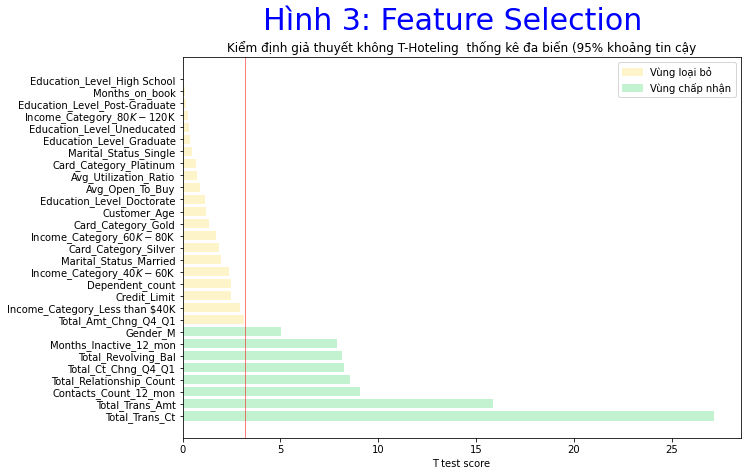

In [ ]:
data_analyst = data_analyst_resamling
data_analyst = pd.get_dummies(data_analyst,drop_first=True) #Xử lý dữ liệu định tính
print(data_analyst.columns)
data_analyst.head(10)
Xtrain = data_analyst.drop(columns =['Attrition_Flag_Existing Customer'])
Ytrain = data_analyst['Attrition_Flag_Existing Customer']
model = sm.OLS(zscore(Ytrain),zscore(Xtrain)).fit()
df = data[data!='Unknown'].dropna()# xoa outlier
T_values = model.tvalues
T_values = pd.Series.sort_values(np.abs(T_values),ascending=False)
colors = np.repeat(['#c2f2d0','#fdf5c9'],[len(T_values[T_values>=3.18]),len(T_values[T_values<3.18])],axis = 0)
fig,ax = plt.subplots(figsize = (10,7))
ax.barh(T_values.index,T_values,color = colors)
ax.axvline(3.18,linewidth=0.5,ls = '-', color='r')
reject = mpatches.Patch(color = '#fdf5c9',label='Vùng loại bỏ')
accept= mpatches.Patch(color = '#c2f2d0',label='Vùng chấp nhận')
ax.legend(handles = [reject,accept])
ax.set_xlabel('T test score')
plt.title('Kiểm định giả thuyết không T-Hoteling  thống kê đa biến (95% khoảng tin cậy')
plt.suptitle('Hình 3: Feature Selection', fontsize='30',color = 'blue')
plt.show()

#### Nhận xét giả thuyết không(Hình 3)
Từ biểu đồ trên kết luận được rằng với 95% interval tình trạng sử dụng thẻ tín dụng của khách hàng chỉ phụ thuộc vào các yếu tố sau:
 1. Tổng số giao dịch trong 12 tháng gần nhất(Total_Trans_Ct)
 2. Tổng số tiền giao dịch trong 12 tháng gần nhất(Total_Trans_Amt)
 3. Tổng số sản phẩm của khách hàng
 4. Tổng số dư quay vòng trên thẻ tín dụng
 5. Số lượng và số tiền thay đổi trong các giao dịch gần nhất
 6. Giới tính
 7. Giới hạn tín dụng
 8. Tình trạng hôn nhân( lập gia đình hay là chưa)
 9. Mức thu nhập( chỉ phụ thuộc vào các cá nhân có thu nhập từ 80k trở xuống)<br>
Đặc biệt tình trạng sử dụng thẻ tín dụng phụ thuộc rất mạnh vào 4 thuộc thuộc tính đầu tiên.

##Phân tích dữ liệu

### Hồi quy tuyến tính

In [ ]:
# Mô hình hoá
columns_ = T_values[T_values>=3.18].index
data_analyst = data_analyst_resamling[columns_]
 #xoá cột ID_name
data_analyst = pd.get_dummies(data_analyst,drop_first=True) #Xử lý dữ liệu định tính
Logit = sm.Logit
Xtrain = data_analyst
Ytrain = data_analyst_resamling['Attrition_Flag_Existing Customer']
model = Logit(Ytrain,Xtrain).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: inf
         Iterations 7
                                  Logit Regression Results                                  
Dep. Variable:     Attrition_Flag_Existing Customer   No. Observations:                 2226
Model:                                        Logit   Df Residuals:                     2218
Method:                                         MLE   Df Model:                            7
Date:                              Sat, 11 Feb 2023   Pseudo R-squ.:                     inf
Time:                                      17:16:37   Log-Likelihood:                   -inf
converged:                                     True   LL-Null:                        0.0000
Covariance Type:                          nonrobust   LLR p-value:                     1.000
                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Nhận xét mô hình 1

### Bayer analyst and Histogram analyst

In [ ]:
def bining(data,lists_name,bins=10):
    df =data
    data_new = pd.DataFrame()
    data_list_bin = pd.DataFrame()
    bins_plits = pd.DataFrame()
    for list_ in lists_name:
        value_cal = df[list_]
        min_ = min(value_cal)
        max_ = max(value_cal)
        step = (max_-min_)/bins
        list_bins = []
        bin_split = []
        for i in range(bins):
            if 0<i<bins-1:
                list_bins.append([round(i*step+min_),round(min_+(i+1)*step)])
                bin_split.append(round(i*step+min_))
                continue
            if i==0:
                list_bins.append([min_,round(min_+(i+1)*step)])
                bin_split.append(min_)
                continue
            if i==bins-1:
                list_bins.append([round(i*step+min_),max_])
                bin_split.append(round(i*step+min_))
                continue
        data_list_bin[list_] = list_bins
        bins_plits[list_] = bin_split
        result = []
        for i in value_cal:
            for j in list_bins:
                if j[0]<=i<=j[1]: 
                    result.append(j[0])
                    break
        data_new[list_]=result
    return data_new,data_list_bin,bins_plits

In [ ]:
data_histogram,data_list_bin,bins_plits = bining(data_analyst_resamling,lists_name = columns_,bins =20)
data_histogram['Attrition_Flag_Existing Customer'] = y_under

#### Histogram Analyst 

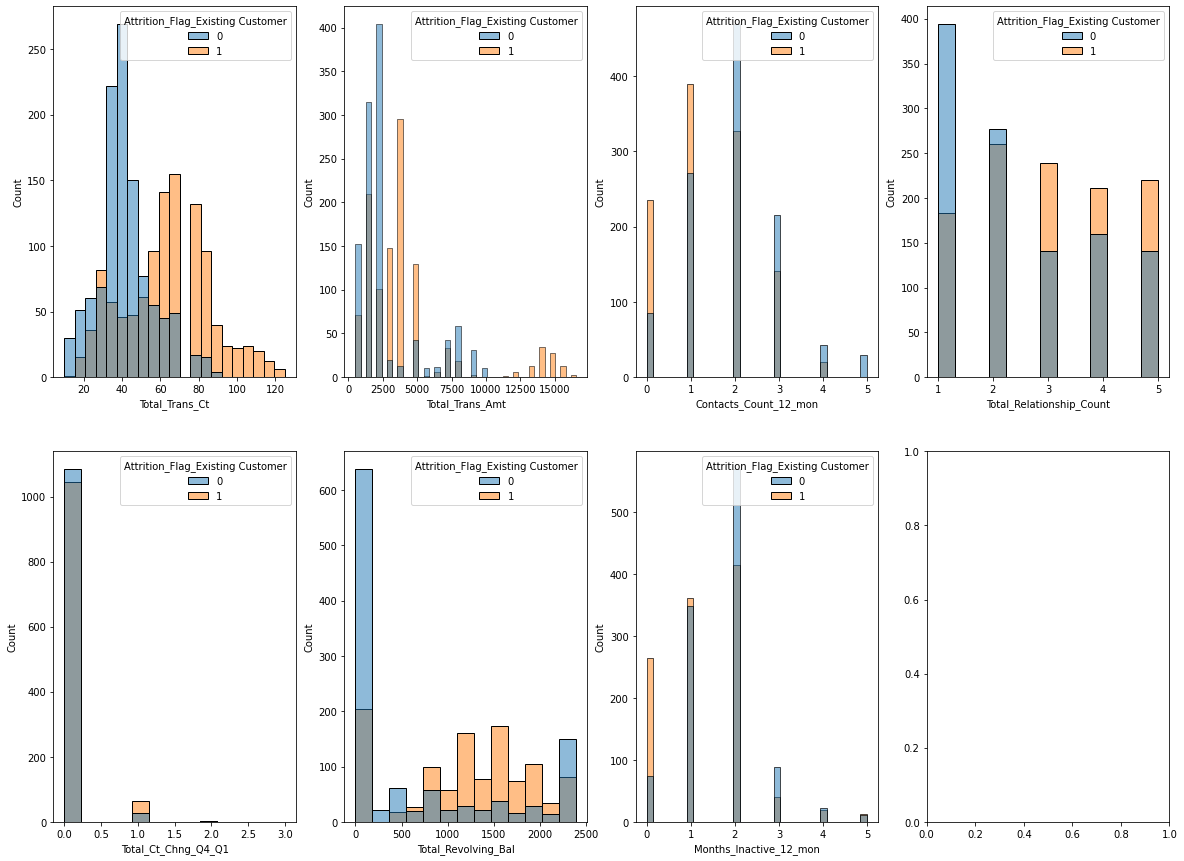

In [ ]:
fig,axs = plt.subplots(2,4,figsize = (20,15))
for i in range(2):
    for j in range(4):
      if i*4+j==7:continue
      sns.histplot(data=data_histogram,x=data_histogram.columns[i*4+j],hue='Attrition_Flag_Existing Customer',ax=axs[i,j])
plt.show()

1. Total_tran_ct: số lượng giao dịch nhỏ thì có xu hướng tiếp tục sử dụng dịch vụ, số giao dịch càng lớn thì càng giảm dần, đặc biệt với số lượng giao dịch từ 80 lần đến 100 lần thì chắc chắn ngưng dùng thẻ tín dụng. Ngân hàng đã không giữ chân được các khách hàng cũ mình kiếm được -> chăm sóc khách hàng không hiệu quả
2. Total_tran_amt: Tổng số tiền giao dịch từ 0-2000 và từ 6000-10000 có xu hướng tiếp tục sử dụng dịch vụ. Từ 2000-6000 có tỉ lệ ngưng dịch vụ cao khoảng 75%. Phân khúc từ 12000-17000 chắc chắn ngưng dịch vụ thẻ tín dụng. Kết luận việc giữ chân các khách hàng thu nhập cao không tốt.
3. Số lần liên hệ của khách hàng trong 12 tháng gần nhất càng lớn thì tỉ lệ khách hàng tiếp tục sử dụng dịch vụ càng cao
4. Tổng số sản phẩm khách hàng nắm giữ nhỉ thì tỉ lệ tiếp tục sử dụng dịch vụ thấp đi
5. Số dư quay vòng trên thẻ tín dụng bằng 0(khách từ bỏ tín dụng gấp 3 lần bình thường) khi số dư lên đến 500 có tỉ lệ rất lớn(khoảng 80%) sẽ ngưng sử dụng dịch vụ. Khi số dư từ 1000-2000 tỉ lệ tiếp tục sử dụng lại tăng lên người từ 2500 trở lên lại tiếp tục không sử dụng tín dụng nữa. Khách hàng có thu nhập cao đang không hài lòng với dịch vụ.
6. Số dư quay vòng trên thẻ tín dụng càng tăng lên thì tỉ lệ rời ngân hàng lại càng lớn. Chứng tỏ họ đã không được đáp ứng yêu cầu khi gọi điện lên tổng đài.

In [ ]:
data_histogram.head(20)

,Total_Trans_Ct,Total_Trans_Amt,Contacts_Count_12_mon,Total_Relationship_Count,Total_Ct_Chng_Q4_Q1,Total_Revolving_Bal,Months_Inactive_12_mon,Gender_M,Attrition_Flag_Existing Customer
0,10,510,2,1,0.0,0,2,0,0
1,16,510,0,1,0.0,755,2,0,0
2,10,510,2,1,0.0,0,2,0,0
3,10,510,3,1,0.0,0,3,0,0
4,22,510,1,2,0.0,2139,2,0,0
5,16,510,2,1,0.0,0,2,0,0
6,10,510,2,1,0.0,0,2,0,0
7,10,510,2,2,0.0,0,1,0,0
8,16,510,2,5,0.0,2391,2,0,0
9,16,510,1,1,0.0,881,2,0,0


In [ ]:
data_bayer_count = pd.DataFrame()
for i in data_histogram.columns:
    if (i == 'Attrition_Flag_Existing Customer') or (i == 'Gender_M'):
      continue
    val1 = list(data_histogram[i])
    val2 = list(bins_plits[i])
    cal = pd.cut(val1,val2,duplicates='drop').value_counts()
    print(i)
    try:
       data_bayer_count[i+' RANGE'] =  cal.index
       data_bayer_count[i+' COUNT'] = list(cal)
    except: continue


Total_Trans_Ct
Total_Trans_Amt
Contacts_Count_12_mon
Total_Relationship_Count
Total_Ct_Chng_Q4_Q1
Total_Revolving_Bal
Months_Inactive_12_mon


In [ ]:
data_bayer_count

,Total_Trans_Ct RANGE,Total_Trans_Ct COUNT,Total_Trans_Amt RANGE,Total_Trans_Amt COUNT,Total_Revolving_Bal RANGE,Total_Revolving_Bal COUNT
0,"(10, 16]",66,"(510, 1354]",525,"(0, 126]",22
1,"(16, 22]",96,"(1354, 2198]",505,"(126, 252]",21
2,"(22, 28]",151,"(2198, 3042]",168,"(252, 378]",38
3,"(28, 34]",279,"(3042, 3886]",308,"(378, 503]",40
4,"(34, 40]",315,"(3886, 4730]",173,"(503, 629]",47
5,"(40, 46]",197,"(4730, 5574]",11,"(629, 755]",67
6,"(46, 52]",138,"(5574, 6418]",18,"(755, 881]",90
7,"(52, 58]",151,"(6418, 7262]",76,"(881, 1007]",79
8,"(58, 64]",186,"(7262, 8106]",77,"(1007, 1133]",97
9,"(64, 70]",204,"(8106, 8950]",33,"(1133, 1258]",92


**Tần số khách hàng ngưng sử dụng dịch vụ**

In [ ]:
data_bayer_count

,Total_Trans_Ct RANGE,Total_Trans_Ct COUNT,Total_Trans_Amt RANGE,Total_Trans_Amt COUNT,Total_Revolving_Bal RANGE,Total_Revolving_Bal COUNT
0,"(10, 16]",66,"(510, 1354]",525,"(0, 126]",22
1,"(16, 22]",96,"(1354, 2198]",505,"(126, 252]",21
2,"(22, 28]",151,"(2198, 3042]",168,"(252, 378]",38
3,"(28, 34]",279,"(3042, 3886]",308,"(378, 503]",40
4,"(34, 40]",315,"(3886, 4730]",173,"(503, 629]",47
5,"(40, 46]",197,"(4730, 5574]",11,"(629, 755]",67
6,"(46, 52]",138,"(5574, 6418]",18,"(755, 881]",90
7,"(52, 58]",151,"(6418, 7262]",76,"(881, 1007]",79
8,"(58, 64]",186,"(7262, 8106]",77,"(1007, 1133]",97
9,"(64, 70]",204,"(8106, 8950]",33,"(1133, 1258]",92


In [ ]:
data_bayer_Atri = pd.DataFrame()
data_histogram_exit = data_histogram[data_histogram['Attrition_Flag_Existing Customer']==0]
for i in data_histogram.columns:
    if i =='Attrition_Flag_Existing Customer' or (i=='Gender_M'): continue
    val1 = list(data_histogram_exit[i])
    val2 = list(bins_plits[i])
    cal = pd.cut(val1,val2,duplicates='drop').value_counts()
    try:
       data_bayer_Atri[i+' RANGE'] =  cal.index
       data_bayer_Atri[i+ ' COUNT'] = list(cal)
    except: continue

**Tần số khách đang sử dụng dịch vụ**

In [ ]:
data_bayer_count

,Total_Trans_Ct RANGE,Total_Trans_Ct COUNT,Total_Trans_Amt RANGE,Total_Trans_Amt COUNT,Total_Revolving_Bal RANGE,Total_Revolving_Bal COUNT
0,"(10, 16]",66,"(510, 1354]",525,"(0, 126]",22
1,"(16, 22]",96,"(1354, 2198]",505,"(126, 252]",21
2,"(22, 28]",151,"(2198, 3042]",168,"(252, 378]",38
3,"(28, 34]",279,"(3042, 3886]",308,"(378, 503]",40
4,"(34, 40]",315,"(3886, 4730]",173,"(503, 629]",47
5,"(40, 46]",197,"(4730, 5574]",11,"(629, 755]",67
6,"(46, 52]",138,"(5574, 6418]",18,"(755, 881]",90
7,"(52, 58]",151,"(6418, 7262]",76,"(881, 1007]",79
8,"(58, 64]",186,"(7262, 8106]",77,"(1007, 1133]",97
9,"(64, 70]",204,"(8106, 8950]",33,"(1133, 1258]",92


####Bayer analyst####

In [ ]:
data_prob = pd.DataFrame()
for i in range(1,np.shape(data_bayer_Atri)[1]+1,2):
    arr1 = data_bayer_Atri.iloc[:,i].to_numpy()
    arr2 = data_bayer_count.iloc[:,i].to_numpy()
    value = np.divide(arr1,arr2)
    value[np.isnan(value)] = 1
    data_prob[data_bayer_Atri.columns[i-1]]=data_bayer_Atri[data_bayer_Atri.columns[i-1]]
    data_prob[data_histogram.columns[i]+'_Atri_prob']=value
    data_prob[data_histogram.columns[i]+'_Exit_prob']=1-value

**Mật độ phân phối xác suất bayer**

In [ ]:
data_prob

,Total_Trans_Ct RANGE,Total_Trans_Amt_Atri_prob,Total_Trans_Amt_Exit_prob,Total_Trans_Amt RANGE,Total_Relationship_Count_Atri_prob,Total_Relationship_Count_Exit_prob,Total_Revolving_Bal RANGE,Total_Revolving_Bal_Atri_prob,Total_Revolving_Bal_Exit_prob
0,"(10, 16]",0.772727,0.227273,"(510, 1354]",0.600000,0.400000,"(0, 126]",1.000000,0.000000
1,"(16, 22]",0.625000,0.375000,"(1354, 2198]",0.800000,0.200000,"(126, 252]",1.000000,0.000000
2,"(22, 28]",0.456954,0.543046,"(2198, 3042]",0.119048,0.880952,"(252, 378]",0.868421,0.131579
3,"(28, 34]",0.795699,0.204301,"(3042, 3886]",0.042208,0.957792,"(378, 503]",0.700000,0.300000
4,"(34, 40]",0.853968,0.146032,"(3886, 4730]",0.248555,0.751445,"(503, 629]",0.425532,0.574468
5,"(40, 46]",0.761421,0.238579,"(4730, 5574]",0.909091,0.090909,"(629, 755]",0.417910,0.582090
6,"(46, 52]",0.557971,0.442029,"(5574, 6418]",0.666667,0.333333,"(755, 881]",0.322222,0.677778
7,"(52, 58]",0.364238,0.635762,"(6418, 7262]",0.565789,0.434211,"(881, 1007]",0.265823,0.734177
8,"(58, 64]",0.241935,0.758065,"(7262, 8106]",0.766234,0.233766,"(1007, 1133]",0.144330,0.855670
9,"(64, 70]",0.240196,0.759804,"(8106, 8950]",0.939394,0.060606,"(1133, 1258]",0.152174,0.847826


**Nhận xét**<br>
Từ bảng phân phối xác xuất, các thống tin chi tiết về mật độ xác xuất từng phân khúc khách hàng. Với Total_Trans_Amt RANGE > 10000 đô la tất cả mọi người đều ngưng sử dụng dịch vụ ngân hàng. Với Total_Revolving_Bal_Atri_prob	< 250 đô la tất cả khách hàng đều vẫn đang sử dụng dịch vụ.

**Biểu đồ xu hướng**

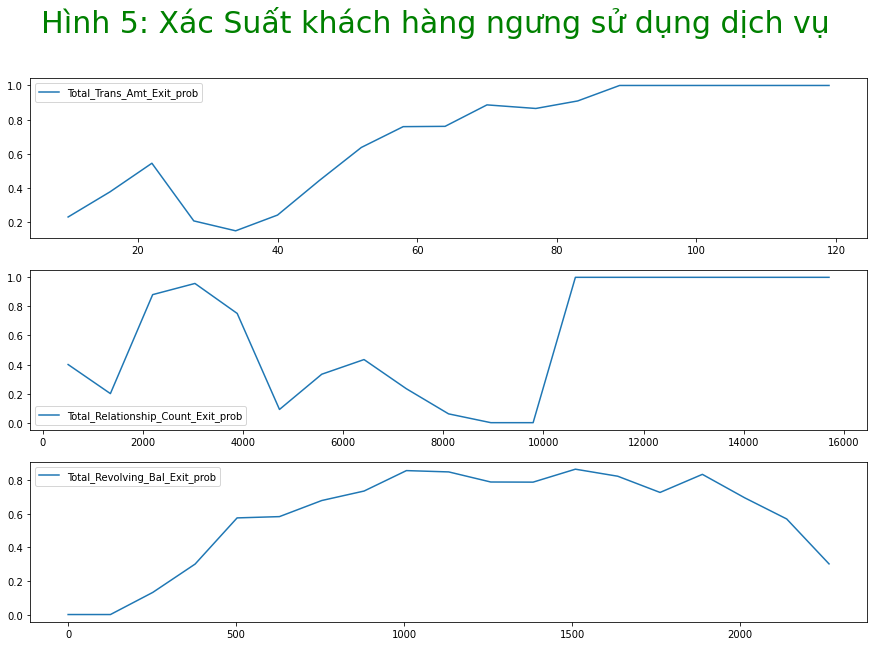

In [ ]:
fig,axs = plt.subplots(3,figsize = (15,10))
n =np.shape(data_prob)[0]
for i in range(3):
    x = [data_prob.iloc[t,3*i].left for t in range(n)]
    axs[i].plot(x,data_prob.iloc[:,3*i+2],label = data_prob.columns[3*i+2])
    axs[i].legend()
plt.suptitle('Hình 5: Xác Suất khách hàng ngưng sử dụng dịch vụ', fontsize='30',color = 'green')
plt.show()

***Nhận xét***

###Desesion tree###

In [ ]:
from sklearn.linear_model import LogisticRegression as glm
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import cross_val_score

Text(0.5, 1.0, ' Hình 6: Ảnh hưởng của alpha tới bộ dữ liệu ')

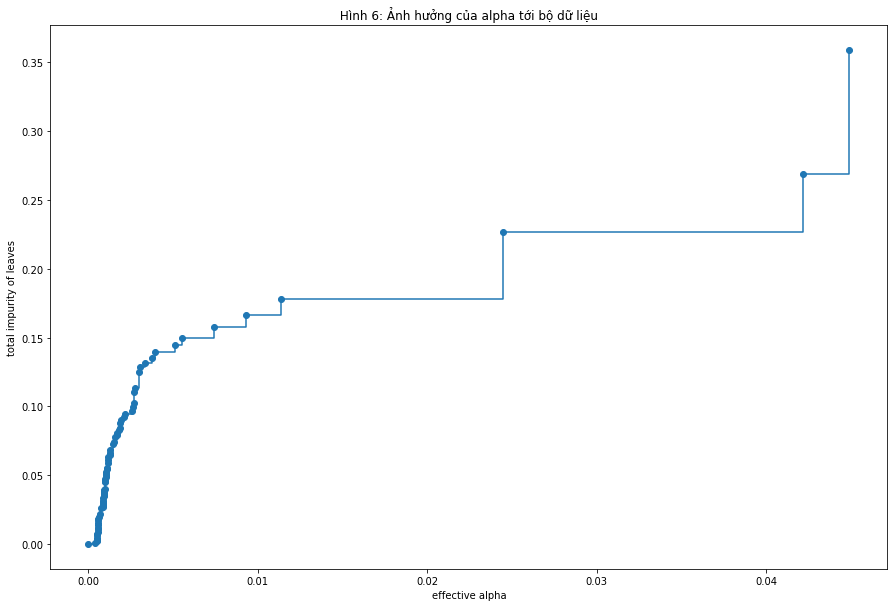

In [ ]:
X = data_analyst_resamling.drop(columns = ['Attrition_Flag_Existing Customer'])
Y = data_analyst_resamling['Attrition_Flag_Existing Customer']
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,Y,test_size = 0.2)
clf = Tree(random_state=0)
path = clf.cost_complexity_pruning_path(Xtrain, Ytrain)
ccp_alphas, prune_tree = path.ccp_alphas, path.impurities
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(ccp_alphas[:-1], prune_tree[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("Ảnh hưởng alpha")
ax.set_ylabel("Tối giản số lá")
ax.set_title(" Hình 6: Ảnh hưởng của alpha tới bộ dữ liệu ")

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import dtreeviz
import matplotlib.font_manage

features = data_analyst_resamling.columns.drop('Attrition_Flag_Existing Customer')
target = 'Attrition_Flag_Existing Customer'
tree_classifier = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_classifier.fit(data_analyst_resamling[features].values, data_analyst_resamling[target].values)
viz_model = dtreeviz.model(tree_classifier,
                           X_train=data_analyst_resamling[features], y_train=data_analyst_resamling[target],
                           feature_names=features,
                           target_name=target, class_names=["Attriting Customer","Existing Customer"])

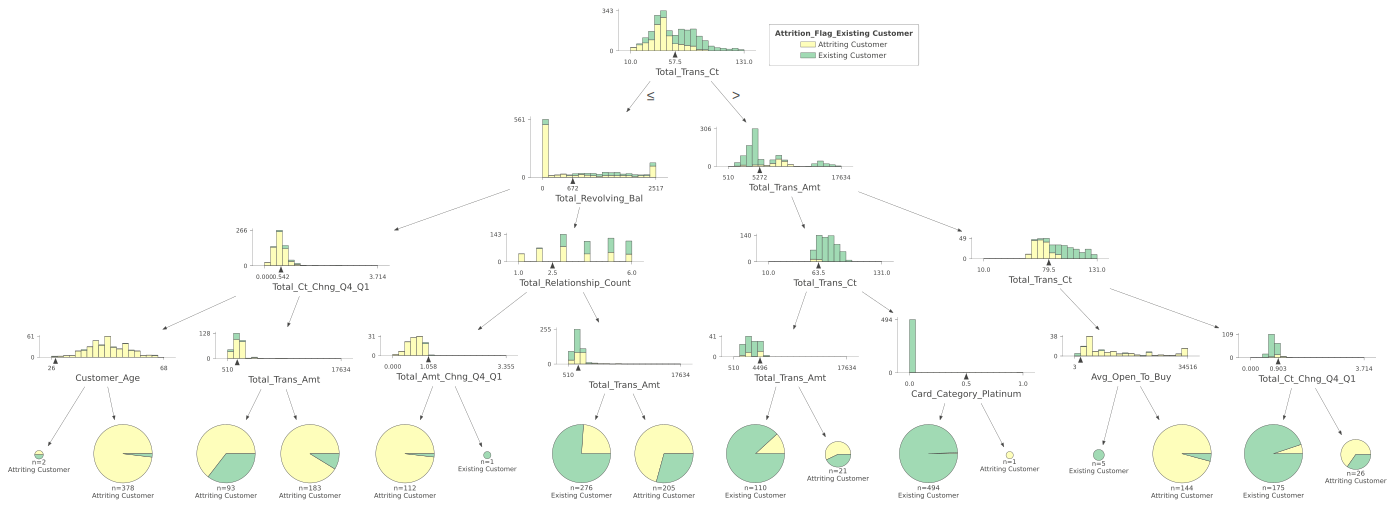

In [ ]:
import logging
logging.getLogger("matplotlib").setLevel(logging.ERROR)
viz_model.view()

**Nhận xét**
Dài quá a Hưng lười viết cho em đi :)